In [1]:
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Dropout
from tensorflow.keras.layers import LSTM
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
from tensorflow.keras.optimizers import Adam
from scipy.signal import savgol_filter
import pandas as pd

In [2]:
class Class_LSTM:
    
    def __init__(self, inputData, window):
        self.df = inputData
        self.meanDf = self.df.mean()
        self.stdDf = self.df.std()
        self.smoothBool = 0
        self.dfNorm = (self.df - self.meanDf) / self.stdDf
        self.window = window
    
    def function_TimeSeriesGenerator(self):
        self.listData = np.array([])
        self.listLabel = np.array([])
        if self.smoothBool == 0:
            for i in range(len(self.dfNorm)-self.window):
                self.tmp_data = self.dfNorm[i:i+self.window]
                self.tmp_label = self.dfNorm[i+self.window]
                self.listData = np.append(self.listData, self.tmp_data)
                self.listLabel = np.append(self.listLabel, self.tmp_label)
            self.arrayData = np.reshape(self.listData, (i+1, self.window,1))
            self.paramShape = (self.window, 1)
        else:
            for i in range(len(self.dfSmooth)-self.window):
                self.tmp_data = self.dfSmooth[i:i+self.window]
                self.tmp_label = self.dfSmooth[i+self.window]
                self.listData = np.append(self.listData, self.tmp_data)
                self.listLabel = np.append(self.listLabel, self.tmp_label)
            self.arrayData = np.reshape(self.listData, (i+1, self.window,1))
            self.paramShape = (self.window, 1)
            

        return self.arrayData, self.listLabel, self.paramShape
    
    def function_Smooth(self, window2):
        self.savgolWindow = window2
        if self.savgolWindow == 0:
            self.smoothBool = 0
        else:
            self.dfSmooth = savgol_filter(self.dfNorm, self.savgolWindow, 2)
            self.smoothBool = 1
        
    
        

    def functionLSTM_Model(self, input_layer, nbHidden=0, drop_out=0):
        self.inputLayer = input_layer
        self.hiddenLayers = nbHidden
        self.lstmShape = np.shape(self.arrayData[1])
        self.drop = drop_out
        self.output_layer = 1
        self.model = Sequential()
        #INPUT LAYER
        if self.hiddenLayers == 0:
            self.model.add(LSTM(self.inputLayer, input_shape = self.lstmShape, return_sequences=False))
            if self.drop != 0:
                    self.model.add(Dropout(self.drop))
        else:
            self.model.add(LSTM(self.inputLayer, input_shape = self.lstmShape, return_sequences=True))
            if self.drop != 0:
                    self.model.add(Dropout(self.drop))

        #HIDDEN LAYER    
        for i in range(0,self.hiddenLayers):
            if i+1 == self.hiddenLayers:
                self.model.add(LSTM(self.inputLayer))
                if self.drop != 0:
                    self.model.add(Dropout(self.drop))
            else:
                self.model.add(LSTM(self.inputLayer, return_sequences=True))
                if self.drop != 0:
                    self.model.add(Dropout(self.drop))
        adamOpti = Adam(lr = 0.001)        
        self.model.add(Dense(1, activation = "linear"))
        self.model.compile(loss='mean_squared_error', optimizer=adamOpti)

        return self.model
    
    def function_Summary(self):
        print(self.model.summary())
    
    def function_Training(self, epok=100, bs=1, val_split=0.2):
        self.epk = epok
        self.sizeBatch = bs
        self.split = val_split
        self.model.fit(self.arrayData, self.listLabel, 
                       epochs=self.epk, 
                       batch_size=self.sizeBatch, 
                       verbose=2, 
                       validation_split=self.split)
        

    def function_Nostradamus(self, windowPredict, plot=True, xmin=0):
        self.X_min = xmin
        self.plot_want = plot
        if self.smoothBool ==0:
            self.predictWindow = windowPredict
            self.nostradamus = np.array(self.dfNorm[-self.window:])
            self.nostradamus = np.reshape(self.nostradamus, (1,self.window,1))
            self.prediction = np.array([])
            for i in range(self.predictWindow):
                self.tmp_pred = self.model.predict(self.nostradamus[i:i+1])
                self.pred_tmp = np.append(self.nostradamus[i], self.tmp_pred)
                self.pred_tmp = self.pred_tmp[1:]
                self.pred_tmp = np.reshape(self.pred_tmp, (self.window,1))               
                self.nostradamus = np.append(self.nostradamus, self.pred_tmp)              
                self.nostradamus = np.reshape(self.nostradamus, (i+2,self.window,1))               
                self.prediction = np.append(self.prediction, self.tmp_pred)
                
            if self.plot_want == True:
                plt.plot((np.linspace(len(self.dfNorm),
                                      len(self.dfNorm) + self.predictWindow - 1,
                                      self.predictWindow)),
                                      self.prediction*self.stdDf+self.meanDf )
                plt.plot(np.linspace(0,len(self.dfNorm) - 1,
                                     len(self.dfNorm)), 
                                     self.dfNorm*self.stdDf+self.meanDf)
                plt.xlim(self.X_min, len(self.dfNorm) + self.predictWindow + 1)
            
            
        else:
            self.predictWindow = windowPredict
            self.nostradamus = np.array(self.dfNorm[-self.window:])
            self.nostradamus = np.reshape(self.nostradamus, (1,self.window,1))
            self.prediction = np.array([])
            for i in range(self.predictWindow):
                self.tmp_pred = self.model.predict(self.nostradamus[i:i+1])
                self.pred_tmp = np.append(self.nostradamus[i], self.tmp_pred)
                self.pred_tmp = self.pred_tmp[1:]
                self.pred_tmp = np.reshape(self.pred_tmp, (self.window,1))               
                self.nostradamus = np.append(self.nostradamus, self.pred_tmp)              
                self.nostradamus = np.reshape(self.nostradamus, (i+2,self.window,1))               
                self.prediction = np.append(self.prediction, self.tmp_pred)
                
            if self.plot_want == True:
                plt.plot((np.linspace(len(self.dfSmooth),
                                      len(self.dfSmooth) + self.predictWindow - 1,
                                      self.predictWindow)),
                                      self.prediction*self.stdDf+self.meanDf )
                plt.plot(np.linspace(0,len(self.dfSmooth) - 1,
                                     len(self.dfSmooth)), 
                                     self.dfSmooth*self.stdDf+self.meanDf)
                plt.xlim(self.X_min, len(self.dfSmooth) + self.predictWindow + 1)
                
        
            

        return self.prediction
    
    
    def function_Plot(self):
        if self.smoothBool == 0:
            self.X = np.linspace(0, len(self.dfNorm) - 1 ,len(self.dfNorm))
            plt.plot(self.X, self.dfNorm, c = 'darkblue')
        else:
            self.X = np.linspace(0, len(self.dfSmooth) - 1 ,len(self.dfSmooth))
            plt.plot(self.X, self.dfSmooth, c = 'darkblue')
            
        

In [3]:
covid_df = pd.read_csv('donnees-hospitalieres-nouveaux-covid19-2021-02-21-19h03.csv', sep=';')
df_2 = covid_df.groupby('jour')['incid_dc', 'incid_rea', 'incid_hosp'].sum()
df_2.head()

<ipython-input-3-c3d099148569>:2: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  df_2 = covid_df.groupby('jour')['incid_dc', 'incid_rea', 'incid_hosp'].sum()


,incid_dc,incid_rea,incid_hosp
jour,,,
2020-03-19,155,438,2229
2020-03-20,83,242,1256
2020-03-21,115,298,1540
2020-03-22,124,309,1534
2020-03-23,189,448,2053


In [4]:
covid = Class_LSTM(df_2['incid_dc'],28)

In [5]:
covid.function_Smooth(11)

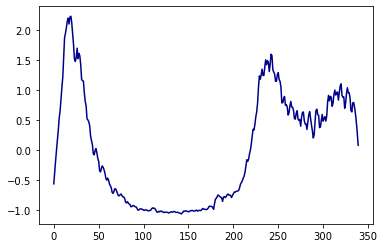

In [6]:
covid.function_Plot()

In [7]:
covid.function_TimeSeriesGenerator()

(array([[[-0.56848651],
         [-0.37159026],
         [-0.18407416],
         ...,
         [ 1.54486947],
         [ 1.69557429],
         [ 1.52192575]],
 
        [[-0.37159026],
         [-0.18407416],
         [-0.00593821],
         ...,
         [ 1.69557429],
         [ 1.52192575],
         [ 1.60738932]],
 
        [[-0.18407416],
         [-0.00593821],
         [ 0.1628176 ],
         ...,
         [ 1.52192575],
         [ 1.60738932],
         [ 1.5685804 ]],
 
        ...,
 
        [[ 0.87811177],
         [ 0.72616207],
         [ 0.7735405 ],
         ...,
         [ 0.78950701],
         [ 0.71093091],
         [ 0.60030596]],
 
        [[ 0.72616207],
         [ 0.7735405 ],
         [ 0.91925125],
         ...,
         [ 0.71093091],
         [ 0.60030596],
         [ 0.45763217]],
 
        [[ 0.7735405 ],
         [ 0.91925125],
         [ 0.99765076],
         ...,
         [ 0.60030596],
         [ 0.45763217],
         [ 0.28290955]]]),
 array([ 1.60738932

In [9]:
covid.functionLSTM_Model(32,0, 0.2)

In [10]:
covid.function_Summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_6 (LSTM)                (None, 32)                4352      
_________________________________________________________________
dropout_6 (Dropout)          (None, 32)                0         
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 33        
Total params: 4,385
Trainable params: 4,385
Non-trainable params: 0
_________________________________________________________________
None


In [11]:
covid.function_Training(epok=5, val_split=0.2)

Epoch 1/5
249/249 - 2s - loss: 0.1622 - val_loss: 0.0286
Epoch 2/5
249/249 - 2s - loss: 0.0267 - val_loss: 0.0238
Epoch 3/5
249/249 - 2s - loss: 0.0191 - val_loss: 0.0224
Epoch 4/5
249/249 - 2s - loss: 0.0178 - val_loss: 0.0228
Epoch 5/5
249/249 - 2s - loss: 0.0144 - val_loss: 0.0221


array([ 4.86775398e-01,  3.87092710e-01,  3.06972593e-01,  2.32550040e-01,
        1.64062187e-01,  9.99158323e-02,  5.70734553e-02,  2.53744051e-02,
       -3.64836678e-02, -9.15257707e-02, -1.38949856e-01, -1.84864506e-01,
       -2.18522236e-01, -2.33630657e-01, -2.43210196e-01, -2.88986176e-01,
       -3.34013462e-01, -3.57773870e-01, -3.91606987e-01, -4.16385978e-01,
       -4.21573311e-01, -4.21150059e-01, -4.52406764e-01, -4.77068782e-01,
       -4.96383131e-01, -5.09890974e-01, -5.31521857e-01, -5.31433105e-01,
       -5.27477384e-01, -5.36146045e-01, -5.42259037e-01, -5.46236992e-01,
       -5.48176944e-01, -5.48168719e-01, -5.46256781e-01, -5.42824090e-01,
       -5.38047552e-01, -5.31280935e-01, -5.22577107e-01, -5.11996984e-01,
       -4.99481440e-01, -4.85162407e-01, -4.69293624e-01, -4.51910585e-01,
       -4.32291567e-01, -4.10305828e-01, -3.86175871e-01, -3.59590858e-01,
       -3.30546349e-01, -2.99242258e-01, -2.65672982e-01, -2.29154587e-01,
       -1.89607590e-01, -

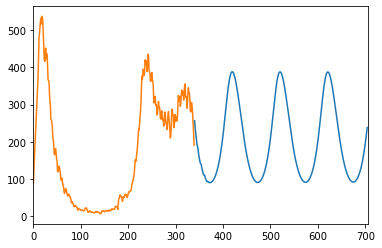

In [15]:
covid.function_Nostradamus(365, xmin = 0, plot = True)

[256.6915483  240.63959915 227.73782    215.75352208 204.72489169
 194.39537471 187.49644707 182.39193446 172.43090057 163.56744546
 155.9307232  148.53706603 143.11714637 140.68423032 139.14163271
 131.77030567 124.51954115 120.69339171 115.24522946 111.25505701
 110.41973845 110.48789501 105.45461336 101.4832773   98.37307886
  96.1979047   92.71467364  92.7289653 ]


ValueError: x and y must have same first dimension, but have shapes (15,) and (28,)

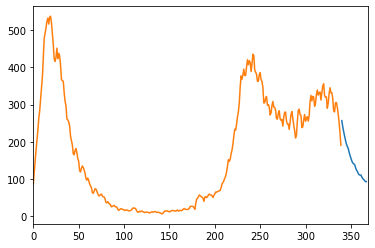

In [13]:
day_pred = 28
yy = covid.function_Nostradamus(day_pred)
print(yy*covid.stdDf+covid.meanDf)
plt.plot((np.linspace(340,354,15)),yy*covid.stdDf+covid.meanDf )
plt.plot(np.linspace(0,339,340), covid.dfSmooth[0:340]*covid.stdDf+covid.meanDf)

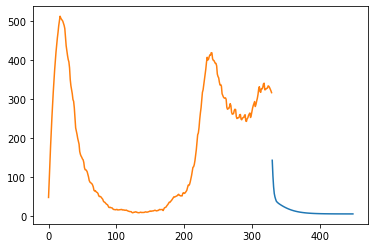

In [134]:
#covid = Class_LSTM(df_2['incid_dc'],15)
#covid.function_Smooth(49)
#covid.functionLSTM_Model(16,1)

yy = covid.function_Nostradamus(120)
plt.plot((np.linspace(330,449,120)),yy*covid.stdDf+covid.meanDf )
plt.plot(np.linspace(0,329,330), covid.dfSmooth[0:330]*covid.stdDf+covid.meanDf)